In [1]:
from fastai2.text.all import *

In [2]:
df = pd.read_csv('data/tweets_100thou.csv')

## Create learner and load saved model

In [3]:
dls_lm = TextDataLoaders.from_df(df, is_lm=True, text_col='text', valid_pct=0.2, bs=128, shuffle_train=False)

/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls_clas = TextDataLoaders.from_df(df, valid_col="is_valid", text_col='text', label_col='target',shuffle_train=False, text_vocab=dls_lm.vocab)

/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [ ]:
learn = learn.load('classifier_81')

## Evaluating the learner

In [217]:
interp = ClassificationInterpretation.from_learner(learn)

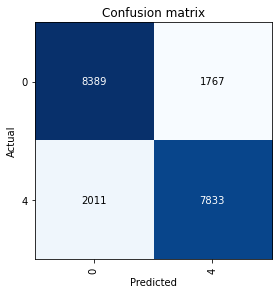

In [218]:
interp.plot_confusion_matrix()

In [219]:
df_toplosses = interp.plot_top_losses(5)

,input,target,predicted,probability,loss
0,xxbos last day of highschool tomorrow xxrep 4 ! so sad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,0,0.9989833235740662,6.8912787437438965
1,xxbos xxunk cool ! thank you thank you xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,4,0.9989431500434875,6.8524675369262695
2,xxbos xxmaj bummed out becuase my twin boys championship baseball game just got cancelled due to wet field . xxmaj stinkin stinks . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,0,0.9979625940322876,6.196087837219238
3,xxbos just woke up wondering why my itunes wo nt play songs and why my printer went spaz at four this morning .. xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,0,0.9978423118591309,6.138705253601074
4,xxbos xxmaj waiting for next storm so i can kite in xxmaj sydney xxmaj heading to cairns soon . xxmaj see green island http : / / xxrep 3 w xxunk / graphs / xxunk xxmaj nice,0,4,0.9938675761222839,5.094171524047852


In [220]:
losses = interp.top_losses()

## Getting predictions

In [221]:
probabilities, targets = learn.get_preds(dl= dls_clas.valid)

In [222]:
learn.predict('grr boys annoy the shit out of me, why cant i just hang with mah girls all the time')

('0', tensor(0), tensor([0.8676, 0.1324]))

In [223]:
learn.predict('this is totally awesome')

('4', tensor(1), tensor([0.0060, 0.9940]))

In [224]:
convert(df_pred['probability_0'][0], df_pred['probability_4'][0])

1

In [225]:
df_pred = pd.DataFrame(data = {
    'probability_0': np.array(probabilities[:,0]),
    'probability_4': np.array(probabilities[:,1]),
    'targets': np.array(targets)
})

In [226]:
df_pred['preds'] = ''

In [227]:
df_pred['preds'] = np.where((df_pred['probability_0'] > df_pred['probability_4']), 0, 1)

In [228]:
df_pred.head()

,probability_0,probability_4,targets,preds
0,0.012769,0.987231,1,1
1,0.906533,0.093467,0,0
2,0.610903,0.389097,0,0
3,0.867641,0.132359,1,0
4,0.688572,0.311428,1,0


the following line of code compare the confusion matrix to the confusion matrix generated from the classifier

In [229]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_pred['targets'], df_pred['preds'])

array([[8389, 1767],
       [2011, 7833]])

## merging predictions with validation dataset

In [230]:
df_valid = df[df['is_valid'] == True ]

In [231]:
df_valid = df_valid[['target', 'text', 'is_valid']].reset_index(drop=True)

In [232]:
df_eval = df_valid.join(df_pred)

Note: 'targets' is the expected target from the `get_preds()` method. It is expected to match up exactly with 'target' col from the validation set

In [233]:
df_eval.head()

,target,text,is_valid,probability_0,probability_4,targets,preds
0,4,Making pasta and insalata blu with mom,True,0.012769,0.987231,1,1
1,0,Worst. Day. Ever. Needing some legitimate hug action. Show starts in 30,True,0.906533,0.093467,0,0
2,0,@HonnyDipp oh no today is not a good day. Aw doll,True,0.610903,0.389097,0,0
3,4,"grr boys annoy the shit out of me, why cant i just hang with mah girls all the time",True,0.867641,0.132359,1,0
4,4,FUCK YOU LORD OF THE FLIES I HATE YOU - bubbleant: O.O You hate it?! I loved it! lol But I read it a long... http://tumblr.com/xbw1t3cwz,True,0.688572,0.311428,1,0


mapping the targets and preditions to the original labels

In [234]:
df_eval['preds'] = df_eval['preds'].replace(1, 4)
df_eval['targets'] = df_eval['targets'].replace(1, 4)

selecting the dataframe with wrong predicitions

In [235]:
df_wrong = df_eval[df_eval['target'] != df_eval['preds']]

In [236]:
df_wrong.head()

,target,text,is_valid,probability_0,probability_4,targets,preds
3,4,"grr boys annoy the shit out of me, why cant i just hang with mah girls all the time",True,0.867641,0.132359,4,0
4,4,FUCK YOU LORD OF THE FLIES I HATE YOU - bubbleant: O.O You hate it?! I loved it! lol But I read it a long... http://tumblr.com/xbw1t3cwz,True,0.688572,0.311428,4,0
9,0,home from school had the shitest day today,True,0.192823,0.807177,0,4
10,0,Is jelous Jennifer got to see Jeff Dunham,True,0.368201,0.631799,0,4
13,4,@esteffi movement after laying around like a couch potato for a few days is always nice! i chewed my first full meal today,True,0.524137,0.475863,4,0


## Evaluating top losses

In [237]:
losses

torch.return_types.topk(
values=tensor([6.8913e+00, 6.8525e+00, 6.1961e+00,  ..., 9.1076e-05, 7.6294e-05,
        3.9577e-05]),
indices=tensor([ 7857,  2312,   773,  ...,  2776, 11439, 17233]))

In [238]:
df_loss = pd.DataFrame(data = {'values': np.array(losses[0])}, index =  np.array(losses[1]))

### merging losses to predictions

In [239]:
sorted_loss = df_eval.join(df_loss)

In [240]:
sorted_loss = sorted_loss.sort_values('values', ascending=False)

In [241]:
sorted_loss.head()

,target,text,is_valid,probability_0,probability_4,targets,preds,values
7857,4,last day of highschool tomorrow!!!! so sad,True,0.998983,0.001017,4,0,6.891279
2312,0,@theu4life219 cool! thank you thank you,True,0.001057,0.998943,0,4,6.852468
773,4,Bummed out becuase my twin boys championship baseball game just got cancelled due to wet field. Stinkin stinks.,True,0.997963,0.002037,4,0,6.196088
17645,4,just woke up wondering why my itunes wont play songs and why my printer went spaz at four this morning..,True,0.997842,0.002158,4,0,6.138705
16906,0,Waiting for next storm so I can kite in Sydney Heading to cairns soon. See green island http://www.seabreeze.com.au/graphs/qld2.asp Nice,True,0.006132,0.993868,0,4,5.094172


### extracting wrong predictions with losses

In [242]:
wrong_sorted_loss = sorted_loss[sorted_loss['target'] != sorted_loss['preds']]

In [243]:
wrong_sorted_loss.head()

,target,text,is_valid,probability_0,probability_4,targets,preds,values
7857,4,last day of highschool tomorrow!!!! so sad,True,0.998983,0.001017,4,0,6.891279
2312,0,@theu4life219 cool! thank you thank you,True,0.001057,0.998943,0,4,6.852468
773,4,Bummed out becuase my twin boys championship baseball game just got cancelled due to wet field. Stinkin stinks.,True,0.997963,0.002037,4,0,6.196088
17645,4,just woke up wondering why my itunes wont play songs and why my printer went spaz at four this morning..,True,0.997842,0.002158,4,0,6.138705
16906,0,Waiting for next storm so I can kite in Sydney Heading to cairns soon. See green island http://www.seabreeze.com.au/graphs/qld2.asp Nice,True,0.006132,0.993868,0,4,5.094172


Conclusion : Some errorneous classification is seen in the original classification of the text that may explain the high errors in the validation prediction.